In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def import_all_csv(path):
    files = os.listdir(path)
    csv_files = [f for f in files if f.endswith('.csv')]
    dataframes = []
    
    for csv_file in csv_files:
        file_path = os.path.join(path, csv_file)
        df = pd.read_csv(file_path, usecols=['Date/Time', 'Close'])
        df.rename(columns={'Date/Time': 'Date', 'Close': f'{os.path.splitext(csv_file)[0]}'}, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        dataframes.append(df)

    if dataframes:
        merged_df = pd.merge(dataframes[0], dataframes[1], on='Date', how='outer')
        for df in dataframes[2:]:
            merged_df = pd.merge(merged_df, df, on='Date', how='outer')
    else:
        merged_df = pd.DataFrame()

    return merged_df

In [9]:
path = r'D:\New folder\OneDrive\Máy tính\finpros'
df = import_all_csv(path)
df.set_index('Date', inplace=True)
df.dropna(inplace=True)
df.sort_index()
df

,FPT,MSN,PNJ,VIC
Date,,,,
2018-12-25 09:15:00,30.89,78.9,67.15,100.1
2018-12-25 09:18:00,30.74,78.8,67.58,100.1
2018-12-26 09:15:00,31.11,80.0,67.36,101.9
2018-12-26 09:20:00,31.11,80.0,67.87,101.7
2018-12-26 09:24:00,31.19,79.9,67.58,101.7
...,...,...,...,...
2020-12-22 14:22:00,58.10,82.8,78.20,105.7
2020-12-22 14:23:00,58.20,82.8,78.20,105.7
2020-12-22 14:24:00,58.20,82.8,78.20,105.7


In [16]:
returns = df.pct_change().dropna()
returns.head()

,FPT,MSN,PNJ,VIC
Date,,,,
2018-12-25 09:18:00,-0.004856,-0.001267,0.006404,0.000000
2018-12-26 09:15:00,0.012036,0.015228,-0.003255,0.017982
2018-12-26 09:20:00,0.000000,0.000000,0.007571,-0.001963
2018-12-26 09:24:00,0.002572,-0.001250,-0.004273,0.000000
2018-12-26 09:32:00,-0.004809,-0.005006,0.003107,-0.005900


# Brownian motion test for series

In [17]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox

In [33]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

def test_stationary(series):
    result = adfuller(series)
    adf_stat = result[0]
    p_value = result[1]
    print(f'ADF Statistic: {adf_stat}')
    print(f'p-value: {p_value}')
    if p_value < 0.05:
        print("- The series is stationary (reject the null hypothesis of unit root).")
    else:
        print("- The series is not stationary (fail to reject the null hypothesis of unit root).")

def test_normality(series):
    stat, p_value = shapiro(series)
    print(f'Statistic: {stat}')
    print(f'p-value: {p_value}')
    
    if p_value > 0.05:
        print("- The series is normally distributed (fail to reject the null hypothesis of normality).")
    else:
        print("- The series is not normally distributed (reject the null hypothesis of normality).")

def test_independence(series):
    result = acorr_ljungbox(series, lags=[10], return_df=True)
    lb_stat = result['lb_stat'].values[0]
    lb_p_value = result['lb_pvalue'].values[0]
    print(result)
    
    if lb_p_value > 0.05:
        print("- The series is independent (fail to reject the null hypothesis of no autocorrelation).")
    else:
        print("- The series is not independent (reject the null hypothesis of no autocorrelation).")

def test_series(series):
    test_stationary(series)
    test_normality(series)
    test_independence(series)

In [111]:
testing_cols = returns.columns

for col in testing_cols:
    print(f'\nTesting for {col}')
    test_series(returns[col])
    print("-" * 30)


Testing for FPT
ADF Statistic: -64.09865856040568
p-value: 0.0
- The series is stationary (reject the null hypothesis of unit root).
Statistic: 0.7572893500328064
p-value: 0.0
- The series is not normally distributed (reject the null hypothesis of normality).
       lb_stat      lb_pvalue
10  835.936779  3.865125e-173
- The series is not independent (reject the null hypothesis of no autocorrelation).
------------------------------

Testing for MSN
ADF Statistic: -29.713303499957384
p-value: 0.0
- The series is stationary (reject the null hypothesis of unit root).
Statistic: 0.6976892948150635
p-value: 0.0
- The series is not normally distributed (reject the null hypothesis of normality).
        lb_stat  lb_pvalue
10  5534.193658        0.0
- The series is not independent (reject the null hypothesis of no autocorrelation).
------------------------------

Testing for PNJ
ADF Statistic: -32.85616950873212
p-value: 0.0
- The series is stationary (reject the null hypothesis of unit root).

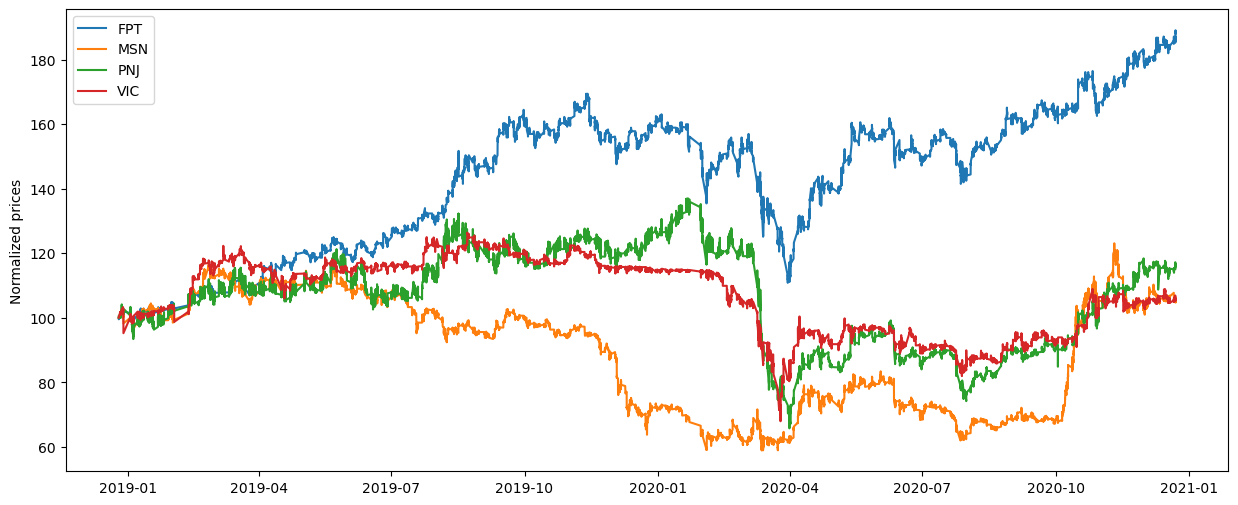

In [12]:
plt.figure(figsize=(15, 6))

for i in range(df.divide(df.iloc[0] / 100).shape[1]):
    normalized_prices = df.divide(df.iloc[0] / 100).iloc[:, i]
    plt.plot(normalized_prices, label=df.divide(df.iloc[0] / 100).columns.values[i])

plt.legend(loc='best')
plt.ylabel('Normalized prices')
plt.show()

In [48]:
tickers = ['FPT', 'MSN', 'PNJ', 'VIC']

data_model = pd.DataFrame()

# create data model with lag features
for ticker in tickers:
    price_col = f'{ticker}'
    data_model[f'price_{ticker}'] = df[price_col]
    data_model[f'target_{ticker}'] = df[price_col].shift(-4) - df[price_col]
    for i in range(5):
        data_model[f'lag_{ticker}_{i}'] = df[price_col].shift(i) - df[price_col].shift(i+1)

data_model.dropna(inplace=True)
data_model.index = pd.to_datetime(data_model.index)
data_model

,price_FPT,target_FPT,lag_FPT_0,lag_FPT_1,lag_FPT_2,lag_FPT_3,lag_FPT_4,price_MSN,target_MSN,lag_MSN_0,...,lag_PNJ_2,lag_PNJ_3,lag_PNJ_4,price_VIC,target_VIC,lag_VIC_0,lag_VIC_1,lag_VIC_2,lag_VIC_3,lag_VIC_4
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-26 09:32:00,31.04,0.11,-0.15,0.08,0.00,0.37,-0.15,79.5,0.3,-0.4,...,0.51,-0.22,0.43,101.1,0.4,-0.6,0.0,-0.2,1.8,0.0
2018-12-26 09:38:00,30.96,0.15,-0.08,-0.15,0.08,0.00,0.37,79.4,0.4,-0.1,...,-0.29,0.51,-0.22,101.1,0.4,0.0,-0.6,0.0,-0.2,1.8
2018-12-26 09:42:00,30.89,0.30,-0.07,-0.08,-0.15,0.08,0.00,79.4,0.4,0.0,...,0.21,-0.29,0.51,101.1,0.4,0.0,0.0,-0.6,0.0,-0.2
2018-12-26 09:55:00,30.96,0.23,0.07,-0.07,-0.08,-0.15,0.08,79.8,0.0,0.4,...,0.00,0.21,-0.29,101.3,0.2,0.2,0.0,0.0,-0.6,0.0
2018-12-26 10:02:00,31.15,-0.04,0.19,0.07,-0.07,-0.08,-0.15,79.8,0.0,0.0,...,-0.07,0.00,0.21,101.5,0.0,0.2,0.2,0.0,0.0,-0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22 14:17:00,58.10,0.00,0.00,0.00,-0.10,0.00,0.10,82.7,0.1,0.0,...,0.00,0.00,-0.10,105.8,-0.1,0.0,-0.1,0.0,0.0,0.0
2020-12-22 14:18:00,58.10,0.10,0.00,0.00,0.00,-0.10,0.00,82.7,0.1,0.0,...,0.00,0.00,0.00,105.8,-0.1,0.0,0.0,-0.1,0.0,0.0
2020-12-22 14:20:00,58.10,0.10,0.00,0.00,0.00,0.00,-0.10,82.7,0.1,0.0,...,0.00,0.00,0.00,105.8,-0.1,0.0,0.0,0.0,-0.1,0.0


In [49]:
from sklearn.linear_model import *
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

## max drawdown, need more review

In [50]:
def backtest_price(price_series, position_series):
    # daily P&L
    bt = pd.DataFrame(price_series.diff() * position_series.shift())
    bt['date'] = [str(i)[:10] for i in bt.index]
    daily_pnl = bt.groupby('date').sum()
    
    # Sharpe ratio
    mean_pnl = daily_pnl.mean()
    std_pnl = daily_pnl.std()
    if std_pnl[0] != 0:
        sharpe_ratio = (mean_pnl / std_pnl * np.sqrt(252))[0]
    else:
        sharpe_ratio = np.nan
    
    # Maximum drawdown
    max_drawdown = (daily_pnl.cummax() - daily_pnl.cumsum()).max() / price_series.max()
    return sharpe_ratio, max_drawdown

# Fit Lasso

In [51]:
np.random.seed(42)

sharpe_ratios = {}
max_drawdowns = {}
accuracy_scores = {}

for ticker in tickers:
    f_names = [col for col in data_model.columns if col.startswith('lag_' + ticker)]
    X = data_model[f_names]
    y = data_model[f'target_{ticker}']
    y_price = data_model[f'price_{ticker}']

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    sharpe = []
    max_drawdown = []
    accuracy = []
    
    model = Lasso(alpha=0.1)
    
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        y_price_train, y_price_test = y_price.iloc[train_index], y_price.iloc[val_index]

        model.fit(X_train, y_train)
        
        y_pred = pd.Series(model.predict(X_val), index=X_val.index)
        y_pred_direction = (y_pred > 0).astype(int)
        y_true_direction = (y_val > 0).astype(int)
        
        accuracy.append(accuracy_score(y_true_direction, y_pred_direction))
        
        strategy_positions = y_pred_direction
        sharpe_ratio, max_dd = backtest_price(y_price_test, strategy_positions)
        sharpe.append(sharpe_ratio)
        max_drawdown.append(max_dd)
    
    sharpe_ratios[ticker] = np.nanmean(sharpe)
    max_drawdowns[ticker] = np.nanmean(max_drawdown)
    accuracy_scores[ticker] = np.mean(accuracy)

for ticker in tickers:
    print(f"Ticker: {ticker}")
    print(f"Mean Sharpe Ratio: {sharpe_ratios[ticker]}")
    print(f"Mean Maximum Drawdown: {max_drawdowns[ticker]}")
    print(f"Mean Accuracy: {accuracy_scores[ticker]}")
    print("-" * 30)

Ticker: FPT
Mean Sharpe Ratio: 1.2890374633806432
Mean Maximum Drawdown: 0.09288221470529193
Mean Accuracy: 0.3242263843648209
------------------------------
Ticker: MSN
Mean Sharpe Ratio: -3.31597808469656
Mean Maximum Drawdown: 0.06707768187422933
Mean Accuracy: 0.5854438110749185
------------------------------
Ticker: PNJ
Mean Sharpe Ratio: 16.23958319238705
Mean Maximum Drawdown: 0.0013317468411807745
Mean Accuracy: 0.5754478827361564
------------------------------
Ticker: VIC
Mean Sharpe Ratio: -1.6077022709417434
Mean Maximum Drawdown: 0.10226220641346125
Mean Accuracy: 0.5312907166123779
------------------------------


The Lasso is good fit for all tickers except for FPT, therefore i will use another strategy: **Pair Trading**

In [55]:
# def tuning(data_model, window_range, alpha_range, n_features_used_range):
#     np.random.seed(42)
#     best_sharpe = -np.inf
#     best_max_drawdown = np.inf
#     best_params = {}

#     tickers = [col.split('_')[1] for col in data_model.columns if col.startswith('price_')]
    
#     for window in window_range:
#         for alpha in alpha_range:
#             for n_features_used in n_features_used_range:
#                 sharpe = []
#                 max_drawdown = []

#                 for ticker in tickers:
#                     f_names1 = [col for col in data_model.columns if col.startswith('lag_' + ticker)]
#                     f_names1 = f_names1[:n_features_used]
#                     model = Lasso(alpha=alpha)
#                     X = data_model[f_names1]
#                     y = data_model[f'target_{ticker}']
#                     y_price = data_model[f'price_{ticker}']

#                     n_splits = 5
#                     tscv = TimeSeriesSplit(n_splits=n_splits)

#                     ticker_sharpe = []
#                     ticker_max_drawdown = []

#                     for train_index, val_index in tscv.split(X):
#                         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#                         y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#                         y_price_train, y_price_test = y_price.iloc[train_index], y_price.iloc[val_index]

#                         model.fit(X_train, y_train)
#                         y_pred = pd.Series(model.predict(X_val), index=X_val.index)
#                         y_pred_direction = (y_pred > 0).astype(int)
#                         y_true_direction = (y_val > 0).astype(int)

#                         strategy_positions = y_pred_direction
#                         sharpe_ratio, max_dd = backtest_price(y_price_test, strategy_positions)
#                         ticker_sharpe.append(sharpe_ratio)
#                         ticker_max_drawdown.append(max_dd)

#                     mean_sharpe = np.mean(ticker_sharpe)
#                     mean_max_drawdown = np.mean(ticker_max_drawdown)

#                     sharpe.append(mean_sharpe)
#                     max_drawdown.append(mean_max_drawdown)

#                 mean_sharpe_overall = np.mean(sharpe)
#                 mean_max_drawdown_overall = np.mean(max_drawdown)

#                 if mean_sharpe_overall > best_sharpe:
#                     best_sharpe = mean_sharpe_overall
#                     best_max_drawdown = mean_max_drawdown_overall
#                     best_params = {'window': window, 'alpha': alpha, 'n_features_used': n_features_used}

#     return best_params, best_sharpe, best_max_drawdown

# Pair Trading

In [57]:
from statsmodels.tsa.stattools import coint

# cointegration test (johansen)
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n,n))
    p_value_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []

    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]

            score_matrix[i, j] = score
            p_value_matrix[i,j] = pvalue

            if pvalue < 0.05:
                pairs.append((keys[i],keys[j]))
    return score_matrix, p_value_matrix, pairs

In [58]:
np.random.seed(42)
_, p_value_matrix, _ = find_cointegrated_pairs(df)

min_pvalue = float('inf')
best_pair = None

for i in range(len(p_value_matrix)):
    for j in range(i+1, len(p_value_matrix)):
        if p_value_matrix[i,j] < min_pvalue:
            min_pvalue = p_value_matrix[i,j]
            best_pair = (df.columns[i], df.columns[j])

print(f'The best pair is: {best_pair} with a p_value of {min_pvalue}')

The best pair is: ('PNJ', 'VIC') with a p_value of 0.06241684428434742


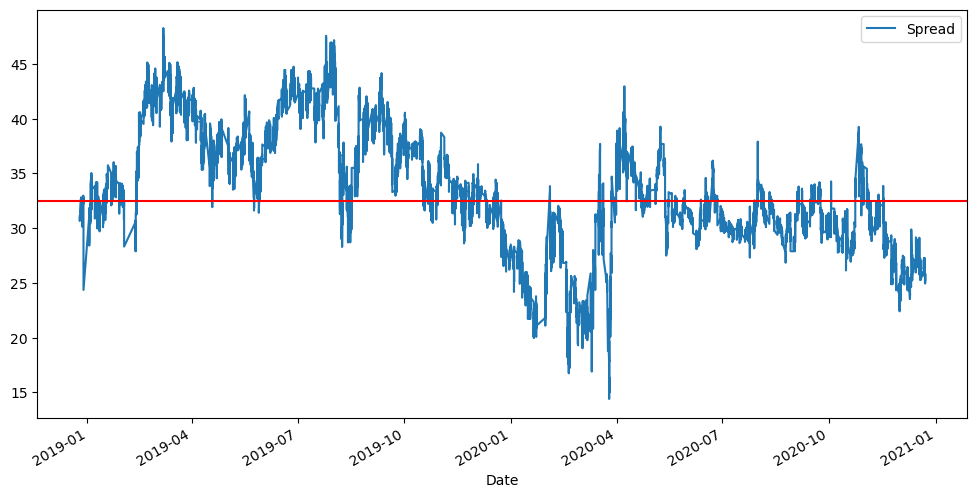

In [59]:
import statsmodels.api as sm

# calculate spread
s1 = df['PNJ']
s2 = df['VIC']
s1 = sm.add_constant(s1)
results = sm.OLS(s2, s1).fit()
s1 = s1['PNJ']
b = results.params['PNJ']

spread = s2 - b * s1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color = 'red')
plt.legend(['Spread'])
plt.show()

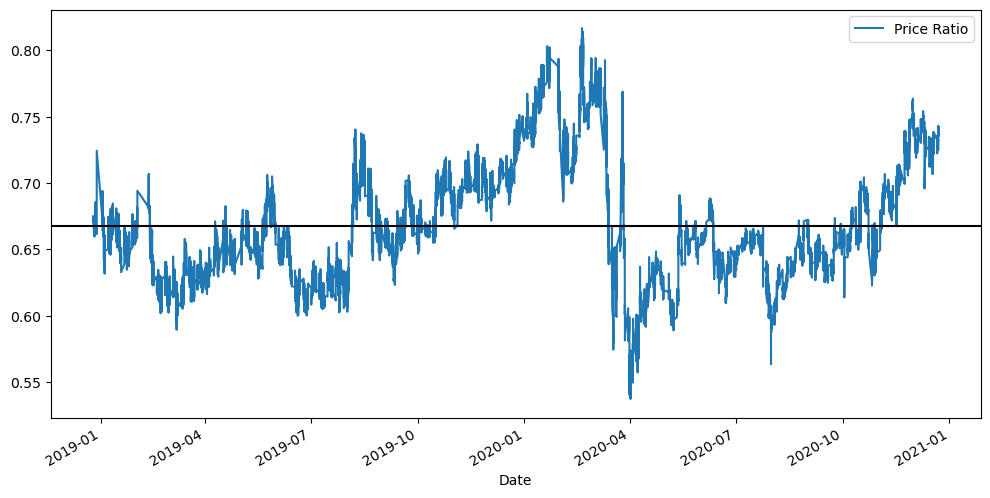

In [60]:
# calculate price ratio
ratio = s1/s2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color = 'black')
plt.legend(['Price Ratio'])
plt.show()

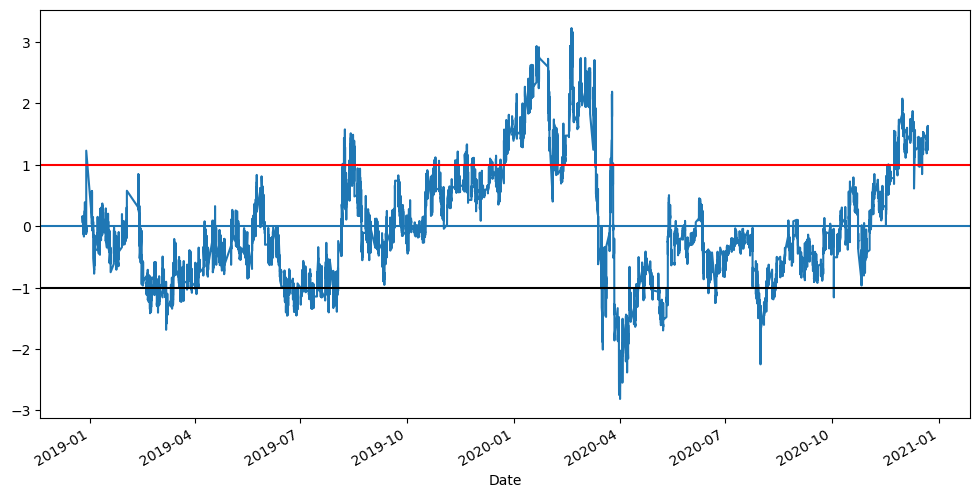

In [61]:
def zscore(series):
    return (series - series.mean())/np.std(series)

zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color = 'red')
plt.axhline(-1.0, color = 'black')
plt.show()

In [62]:
ratios = df['PNJ'] / df['VIC']
print(len(ratios) * 0.7)

41267.799999999996


In [63]:
train_set = ratios[:int(len(ratios)*0.7)]
test_set = ratios[int(len(ratios)*0.7):]

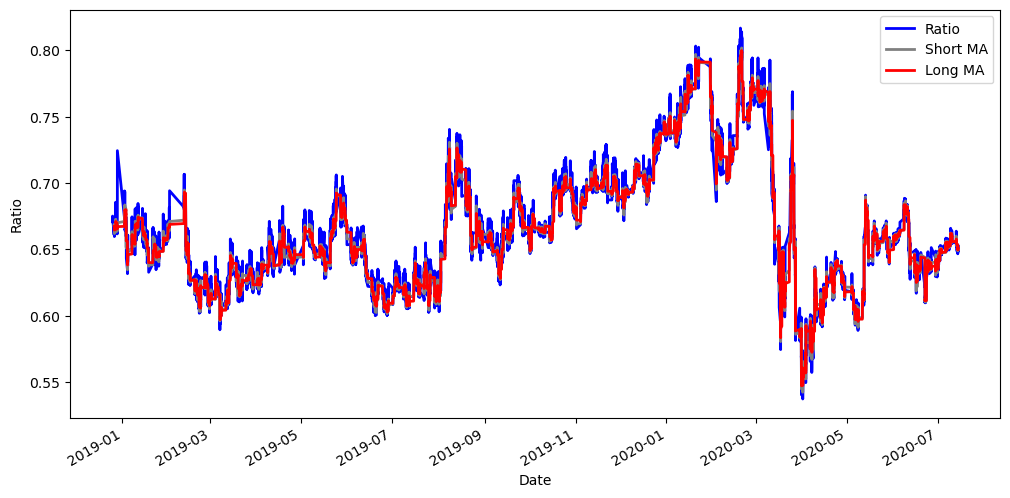

In [68]:
# indicator incorporation using simple MA
ratios_mavg_short = train_set.rolling(window = 12, center=False).mean()
ratios_mavg_long = train_set.rolling(window = 36, center=False).mean()
std_long = train_set.rolling(window = 36, center = False).std()
z_score = (ratios_mavg_short - ratios_mavg_long)/std_long
plt.figure(figsize=(12,6))
train_set.plot(color='blue', linewidth=2)
ratios_mavg_short.plot(color='grey', linewidth=2)
ratios_mavg_long.plot(color='red', linewidth=2)
plt.legend(['Ratio', 'Short MA', 'Long MA'])
plt.ylabel('Ratio')
plt.show()

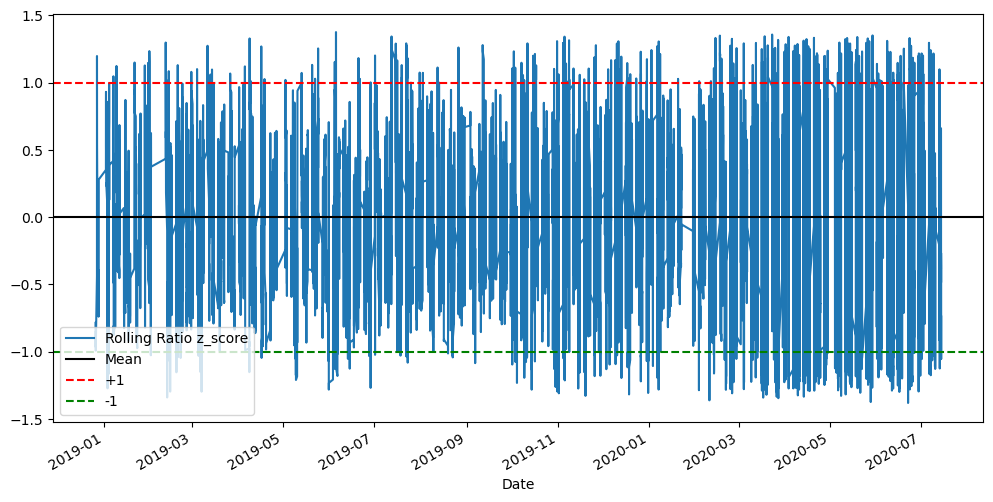

In [69]:
plt.figure(figsize=(12,6))
z_score.plot()
plt.axhline(0, color = 'black')
plt.axhline(1.0, color = 'red', linestyle = '--')
plt.axhline(-1.0, color = 'green', linestyle = '--')
plt.legend(['Rolling Ratio z_score', 'Mean', '+1', '-1'])
plt.show()

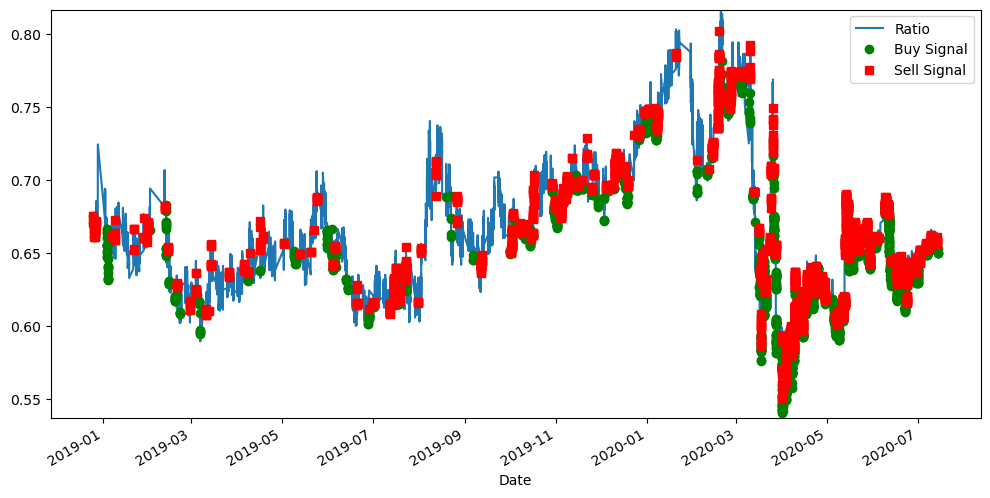

In [102]:
plt.figure(figsize=(12,6))

train_set.plot()
buy = train_set.copy()
sell = train_set.copy()
buy[z_score>-1] = 0
sell[z_score<1] = 0
buy.plot(color='g', linestyle='None', marker='o')
sell.plot(color='r', linestyle='None', marker='s')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

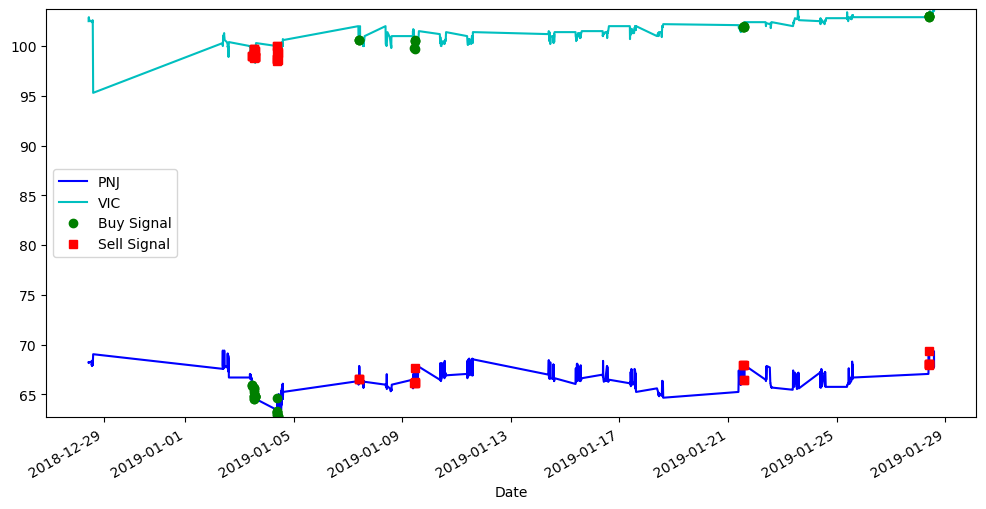

In [166]:
plt.figure(figsize=(12,6))
S1 = df['PNJ'].iloc[:1000]
S2 = df['VIC'].iloc[:1000]

S1[100:].plot(color='b')
S2[100:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# buy the ratio, buy PNJ and sell VIC
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# sell the ratio, sell PNJ and buy VIC
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[100:].plot(color='g', linestyle='None', marker='o')
sellR[100:].plot(color='r', linestyle='None', marker='s')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.legend(['PNJ', 'VIC', 'Buy Signal', 'Sell Signal'])
plt.show()

In [167]:
def trade(S1, S2, window1, window2):
    if (window1 == 0) or (window2 == 0):
        return pd.DataFrame(columns=['Number of trades', 'Position', 'PnL']), 0
    
    # trade the ratios with simple MA smoothing
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std
    
    trades_list = []
    
    money = 0
    countS1 = 0
    countS2 = 0
    trade_counter = 0
    
    for i in range(len(ratios)):
        trade_info = {}

        # short sell if the z-score < -1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            trade_info['Position'] = '-1'
            trade_info['PnL'] = S1[i] - S2[i] * ratios[i]
            trade_counter += 1

        # long if the z-score > 1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            trade_info['Position'] = '1'
            trade_info['PnL'] = -(S1[i] - S2[i] * ratios[i])
            trade_counter += 1

        # neutral if the z-score between -0.75 and 0.75
        elif abs(zscore[i]) < 0.75:
            current_pnl = S1[i] * countS1 + S2[i] * countS2
            money += current_pnl
            trade_info['Position'] = '0'
            trade_info['PnL'] = current_pnl
            countS1 = 0
            countS2 = 0
            if current_pnl != 0:
                trade_counter += 1
            
        trade_info['Number of trades'] = trade_counter
        trades_list.append(trade_info)

    trade_tracker = pd.DataFrame(trades_list, columns=['Number of trades', 'Position', 'PnL'])
    
    trade_tracker['Cumulative PnL'] = trade_tracker['PnL'].cumsum()
    
    returns = trade_tracker['Cumulative PnL'].diff().dropna()
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)

    return trade_tracker, sharpe_ratio

In [168]:
trade_tracker, sharpe_ratio = trade(df['PNJ'].iloc[:int(len(df)*0.7)], df['VIC'].iloc[:int(len(df)*0.7)], 60, 5)

print("Pnl tracker:")
print(trade_tracker)
print("\nAnnualized Sharpe Ratio:", sharpe_ratio)

Pnl tracker:
       Number of trades Position  PnL  Cumulative PnL
0                     0      NaN  NaN             NaN
1                     0      NaN  NaN             NaN
2                     0      NaN  NaN             NaN
3                     0      NaN  NaN             NaN
4                     0      NaN  NaN             NaN
...                 ...      ...  ...             ...
41262             26645        1 -0.0     8354.383276
41263             26646        1 -0.0     8354.383276
41264             26647        1 -0.0     8354.383276
41265             26648        1 -0.0     8354.383276
41266             26649        1 -0.0     8354.383276

[41267 rows x 4 columns]

Annualized Sharpe Ratio: 0.9359278535241534


In [169]:
def tune_trade_parameters(S1, S2, window1_range, window2_range):
    best_sharpe = -np.inf
    best_params = {}

    for window1 in window1_range:
        for window2 in window2_range:
            trade_tracker, sharpe_ratio = trade(S1, S2, window1, window2)
            if sharpe_ratio > best_sharpe:
                best_sharpe = sharpe_ratio
                best_params = {'window1': window1, 'window2': window2}

    return best_params, best_sharpe

In [170]:
window1_range = [30, 60, 90, 120, 150, 180, 210, 240]
window2_range = [5, 10, 15, 20, 25, 30, 35, 40]

best_params, best_sharpe = tune_trade_parameters(S1, S2, window1_range, window2_range)

print("Best Parameters:", best_params)
print("Best Mean Sharpe Ratio:", best_sharpe)

Best Parameters: {'window1': 210, 'window2': 40}
Best Mean Sharpe Ratio: 1.8093593905958973


In [171]:
OS_trade_tracker, OS_sharpe_ratio = trade(df['PNJ'].iloc[int(len(df)*0.7):], df['VIC'].iloc[int(len(df)*0.7):], best_params['window1'], best_params['window2'])

print("OS Sharpe Ratio:", OS_sharpe_ratio)
print(OS_trade_tracker)

OS Sharpe Ratio: 0.005448993090398692
       Number of trades Position  PnL  Cumulative PnL
0                     0      NaN  NaN             NaN
1                     0      NaN  NaN             NaN
2                     0      NaN  NaN             NaN
3                     0      NaN  NaN             NaN
4                     0      NaN  NaN             NaN
...                 ...      ...  ...             ...
17682             10989       -1  0.0     1643.170222
17683             10990       -1  0.0     1643.170222
17684             10991       -1  0.0     1643.170222
17685             10992       -1  0.0     1643.170222
17686             10993       -1  0.0     1643.170222

[17687 rows x 4 columns]


# Portfolio Optimization

In [126]:
train_set = df[:int(len(df)*0.7)]
test_set = df[int(len(df)*0.7):]

In [136]:
from feature_engine.selection import DropCorrelatedFeatures

thresholds = [0.4, 0.5]
train_dfs = {}

# drop correlated features that beyond the threshold levels
for threshold in thresholds:
    tr = DropCorrelatedFeatures(
        variables=None,
        method='pearson',
        threshold=threshold
    )
    train_df = tr.fit_transform(train_set)
    train_dfs[f'train_{int(threshold * 10):02}'] = train_df

In [139]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import EfficientSemivariance
from pypfopt import EfficientCVaR
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.cla import CLA

In [165]:
# equally-weighted-portfolio
return_04 = test_set[train_dfs['train_04'].columns].pct_change().dropna()

ex_ret_corr_04 = return_04.mean()
ex_ret_array_04 = np.array(ex_ret_corr_04)

std_corr_04 = return_04.std()
std_array_04 = np.array(std_corr_04)

cov_matrix_04 = return_04.cov().values

trading_days = 252

annualized_return_04 = ex_ret_array_04 * trading_days
annualized_std_04 = std_array_04 * np.sqrt(trading_days)
annualized_cov_matrix_04 = cov_matrix_04 * trading_days

num_assets_04 = len(test_set[train_dfs['train_04'].columns].columns)
equal_weight_04 = 1.0 / num_assets_04
weights_04 = np.array([equal_weight_04] * num_assets_04)

portfolio_annual_return_04 = np.dot(weights_04, annualized_return_04)
portfolio_annual_std_04 = np.sqrt(np.dot(weights_04.T, np.dot(annualized_cov_matrix_04, weights_04)))

risk_free_rate_annual = 0 # autoset at 0, can be replace by 10-year gov bonds
portfolio_sharpe_ratio_04 = (portfolio_annual_return_04 - risk_free_rate_annual) / portfolio_annual_std_04

print("Annualized Portfolio Return:", portfolio_annual_return_04)
print("Annualized Portfolio Standard Deviation:", portfolio_annual_std_04)
print("Annualized Portfolio Sharpe Ratio:", portfolio_sharpe_ratio_04)

Annualized Portfolio Return: 0.003858923193799017
Annualized Portfolio Standard Deviation: 0.02452012821863768
Annualized Portfolio Sharpe Ratio: 0.1573777738595127


In [143]:
# efficient frontier
mu = expected_returns.mean_historical_return(test_set[train_dfs['train_04'].columns])
s = risk_models.CovarianceShrinkage(test_set[train_dfs['train_04'].columns]).ledoit_wolf()
ef = EfficientFrontier(mu, s)
weights = ef.max_sharpe(risk_free_rate=0)
ef.portfolio_performance(verbose=True)

Expected annual return: 0.3%
Annual volatility: 2.2%
Sharpe Ratio: 0.14


(0.003082200914373658, 0.021823686638803384, 0.14123190849402054)

In [145]:
# efficient semivariance
mu = expected_returns.mean_historical_return(test_set[train_dfs['train_04'].columns])
historical_returns = expected_returns.returns_from_prices(test_set[train_dfs['train_04'].columns])
es = EfficientSemivariance(mu, historical_returns)
es.max_quadratic_utility()
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

OrderedDict([('FPT', 0.47426), ('PNJ', 0.52574)])
Expected annual return: 0.3%
Annual semi-deviation: 1.8%
Sortino Ratio: -0.94


(0.003364873579590949, 0.017753024975541706, -0.9370305310406097)

In [151]:
# black-litterman
cov_matrix = risk_models.sample_cov(test_set[train_dfs['train_04'].columns])
viewdict = {"FPT": 0.10, "PNJ": 0.08}

bl = BlackLittermanModel(cov_matrix, absolute_views=viewdict)

rets = bl.bl_returns()
ef = EfficientFrontier(rets, cov_matrix)

delta = black_litterman.market_implied_risk_aversion(rets)
prior = black_litterman.market_implied_prior_returns(viewdict, delta, cov_matrix)

weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 5.0%
Annual volatility: 2.1%
Sharpe Ratio: 1.44


(0.050389938364546555, 0.02109544499076669, 1.440592430159591)

In [152]:
# # HRP
# cov_matrix = risk_models.CovarianceShrinkage(test_set[train_dfs['train_04'].columns]).ledoit_wolf()
# mu = mean_historical_return(test_set[train_dfs['train_04'].columns])
# mu = pd.DataFrame(mu, columns=["returns"])

# print("Covariance Matrix:")
# print(cov_matrix)
# print("\nExpected Returns:")
# print(mu)

# try:
#     hrp = HRPOpt(mu, cov_matrix=cov_matrix)
# except ValueError as e:
#     print(f"Error initializing HRPOpt: {e}")

# try:
#     weights = hrp.optimize(linkage_method='single')
#     if weights is None or len(weights) == 0:
#         raise ValueError("Optimization did not produce valid weights.")
# except ValueError as e:
#     print(f"Error optimizing portfolio weights: {e}")

# if weights is not None and len(weights) > 0:
#     print("\nPortfolio Weights:")
#     print(weights)

#     try:
#         hrp.portfolio_performance(verbose=True, risk_free_rate=0.0288)
#     except ValueError as e:
#         print(f"Error calculating portfolio performance: {e}")
# else:
#     print("Optimization did not produce valid weights.")

Covariance Matrix:
          FPT       PNJ
FPT  0.000537  0.000123
PNJ  0.000123  0.001617

Expected Returns:
      returns
FPT  0.002562
PNJ  0.004089
Error optimizing portfolio weights: The number of observations cannot be determined on an empty distance matrix.

Portfolio Weights:
OrderedDict([('FPT', 0.8320137740133501), ('PNJ', 0.1679862259866498)])
Error calculating portfolio performance: Weights is None


In [153]:
# critical line algorithm
cov_matrix = risk_models.sample_cov(test_set[train_dfs['train_04'].columns])
mu = mean_historical_return(test_set[train_dfs['train_04'].columns])
cla = CLA(mu, cov_matrix)

try:
    weights = cla.max_sharpe()
except ValueError as e:
    print(f"Error optimizing portfolio for maximum Sharpe ratio: {e}")

if weights is not None and len(weights) > 0:
    print("\nPortfolio Weights:")
    print(weights)

    try:
        expected_return, volatility, sharpe_ratio = cla.portfolio_performance(verbose=True)
        print(f"\nExpected annual return: {expected_return}")
        print(f"Volatility: {volatility}")
        print(f"Sharpe Ratio: {sharpe_ratio}")
    except ValueError as e:
        print(f"Error calculating portfolio performance: {e}")
else:
    print("Optimization did not produce valid weights.")


Portfolio Weights:
OrderedDict([('FPT', 0.6667122724220329), ('PNJ', 0.33328772757796715)])
Expected annual return: 0.3%
Annual volatility: 2.2%
Sharpe Ratio: -0.78

Expected annual return: 0.003070939779179918
Volatility: 0.021687265907889344
Sharpe Ratio: -0.7805990986932875


In [163]:
import warnings

thresholds = [0.4, 0.5]

results = []

# views of Black-Litterman Allocation
viewdict_04 = {"FPT": 0.10, "PNJ": 0.08}
viewdict_05 = {"FPT": 0.10, "MSN": 0.05, "PNJ": 0.08}

viewdicts = {
    0.4: viewdict_04,
    0.5: viewdict_05,
}

for threshold in thresholds:
    warnings.filterwarnings("ignore", category=UserWarning)

    tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=threshold)
    train_df = tr.fit_transform(train_set)
    
    returns = test_set[train_df.columns].pct_change().dropna()

    # Equally-Weighted optimization
    ex_ret_corr = returns.mean()
    ex_ret_array = np.array(ex_ret_corr)
    
    std_corr = returns.std()
    std_array = np.array(std_corr)
    
    cov_matrix = returns.cov().values
    
    trading_days = 252
    annualized_return = ex_ret_array * trading_days
    annualized_std = std_array * np.sqrt(trading_days)
    annualized_cov_matrix = cov_matrix * trading_days
    
    num_assets = len(train_df.columns)
    equal_weight = 1.0 / num_assets
    weights = np.array([equal_weight] * num_assets)
    
    portfolio_annual_return = np.dot(weights, annualized_return)
    portfolio_annual_std = np.sqrt(np.dot(weights.T, np.dot(annualized_cov_matrix, weights)))
    portfolio_sharpe_ratio = (portfolio_annual_return - 0.0288) / portfolio_annual_std
    
    results.append({
        'threshold': threshold,
        'method': 'Equally Weighted',
        'expected return': portfolio_annual_return,
        'standard deviation': portfolio_annual_std,
        'sharpe ratio': portfolio_sharpe_ratio
    })
    
    # Efficient Frontier optimization
    mu = mean_historical_return(test_set[train_df.columns])
    s = risk_models.CovarianceShrinkage(test_set[train_df.columns]).ledoit_wolf()
    ef = EfficientFrontier(mu, s)
    weights_ef = ef.max_sharpe(risk_free_rate=0)
    ef_portfolio_return, ef_portfolio_std, ef_portfolio_sharpe = ef.portfolio_performance()
    
    results.append({
        'threshold': threshold,
        'method': 'Efficient Frontier',
        'expected return': ef_portfolio_return,
        'standard deviation': ef_portfolio_std,
        'sharpe ratio': ef_portfolio_sharpe
    })
    
    # Efficient Semivariance optimization (Quadratic Utility)
    historical_returns = expected_returns.returns_from_prices(test_set[train_df.columns])
    es_quad_utility = EfficientSemivariance(mu, historical_returns)
    es_quad_utility.max_quadratic_utility()
    weights_quad_utility = es_quad_utility.clean_weights()
    es_quad_utility_portfolio_return, es_quad_utility_portfolio_std, es_quad_utility_portfolio_sharpe = es_quad_utility.portfolio_performance()
    
    results.append({
        'threshold': threshold,
        'method': 'Efficient Semivariance (Quadratic Utility)',
        'expected return': es_quad_utility_portfolio_return,
        'standard deviation': es_quad_utility_portfolio_std,
        'sharpe ratio': es_quad_utility_portfolio_sharpe
    })

    # Efficient Semivariance optimization (Min SemiVariance)
    historical_returns = expected_returns.returns_from_prices(test_set[train_df.columns])
    es_min_semivariance = EfficientSemivariance(mu, historical_returns)
    es_min_semivariance.min_semivariance()
    weights_quad_utility = es_min_semivariance.clean_weights()
    es_quad_utility_portfolio_return, es_quad_utility_portfolio_std, es_quad_utility_portfolio_sharpe = es_min_semivariance.portfolio_performance()
    
    results.append({
        'threshold': threshold,
        'method': 'Efficient Semivariance (Min SemiVariance)',
        'expected return': es_quad_utility_portfolio_return,
        'standard deviation': es_quad_utility_portfolio_std,
        'sharpe ratio': es_quad_utility_portfolio_sharpe
    })

    # # Efficient Semivariance optimization (Efficient Risk)
    # historical_returns = expected_returns.returns_from_prices(test_set[train_df.columns])
    # es_efficient_risk = EfficientSemivariance(mu, historical_returns)
    # es_efficient_risk.efficient_risk(target_semideviation = 0.1)
    # weights_quad_utility = es_efficient_risk.clean_weights()
    # es_quad_utility_portfolio_return, es_quad_utility_portfolio_std, es_quad_utility_portfolio_sharpe = es_efficient_risk.portfolio_performance()
    
    # results.append({
    #     'threshold': threshold,
    #     'method': 'Efficient Semivariance (Efficient Risk)',
    #     'expected return': es_quad_utility_portfolio_return,
    #     'standard deviation': es_quad_utility_portfolio_std,
    #     'sharpe ratio': es_quad_utility_portfolio_sharpe
    # })

    # # Efficient Semivariance optimization (Efficient Return)
    # historical_returns = expected_returns.returns_from_prices(test_set[train_df.columns])
    # es_efficient_return = EfficientSemivariance(mu, historical_returns)
    # es_efficient_return.efficient_return(target_return = 0.02)
    # weights_quad_utility = es_efficient_return.clean_weights()
    # es_quad_utility_portfolio_return, es_quad_utility_portfolio_std, es_quad_utility_portfolio_sharpe = es_efficient_return.portfolio_performance()
    
    # results.append({
    #     'threshold': threshold,
    #     'method': 'Efficient Semivariance (Efficient Return)',
    #     'expected return': es_quad_utility_portfolio_return,
    #     'standard deviation': es_quad_utility_portfolio_std,
    #     'sharpe ratio': es_quad_utility_portfolio_sharpe
    # })
    
    # Black-Litterman Allocation optimization
    try:
        viewdict = viewdicts.get(threshold)
        if viewdict:
            cov_matrix = risk_models.sample_cov(test_set[train_df.columns])
            bl = BlackLittermanModel(cov_matrix, absolute_views=viewdict)
            rets = bl.bl_returns()
            ef_bl = EfficientFrontier(rets, cov_matrix)
            delta = black_litterman.market_implied_risk_aversion(rets)
            prior = black_litterman.market_implied_prior_returns(viewdict, delta, cov_matrix)
            weights_bl = ef_bl.max_sharpe()
            bl_portfolio_return, bl_portfolio_std, bl_portfolio_sharpe = ef_bl.portfolio_performance()
            
            results.append({
                'threshold': threshold,
                'method': 'Black-Litterman Allocation',
                'expected return': bl_portfolio_return,
                'standard deviation': bl_portfolio_std,
                'sharpe ratio': bl_portfolio_sharpe
            })
        else:
            print(f"No viewdict defined for threshold {threshold}. Skipping Black-Litterman Allocation.")
    
    except ValueError as e:
        print(f"Error optimizing portfolio for Black-Litterman Allocation for threshold {threshold}: {e}")
    
    # Critical Line Algorithm optimization
    try:
        mu_cla = mean_historical_return(test_set[train_df.columns])
        cov_matrix_cla = risk_models.sample_cov(test_set[train_df.columns])
        cla = CLA(mu_cla, cov_matrix_cla)
        
        weights_cla = cla.max_sharpe()
        
        if weights_cla is not None and len(weights_cla) > 0:
            cla_portfolio_return, cla_portfolio_std, cla_portfolio_sharpe = cla.portfolio_performance(verbose=False)
            
            results.append({
                'threshold': threshold,
                'method': 'Critical Line Algorithm',
                'expected return': cla_portfolio_return,
                'standard deviation': cla_portfolio_std,
                'sharpe ratio': cla_portfolio_sharpe
            })
        else:
            print(f"Optimization did not produce valid weights for threshold {threshold}.")
    
    except ValueError as e:
        print(f"Error optimizing portfolio for maximum Sharpe ratio using CLA for threshold {threshold}: {e}")

results_df = pd.DataFrame(results)
results_df

,threshold,method,expected return,standard deviation,sharpe ratio
0,0.4,Equally Weighted,0.003859,0.024520,-1.017167
1,0.4,Efficient Frontier,0.003082,0.021824,0.141232
2,0.4,Efficient Semivariance (Quadratic Utility),0.003365,0.017753,-0.937031
3,0.4,Efficient Semivariance (Min SemiVariance),0.002683,0.015251,-1.135474
4,0.4,Black-Litterman Allocation,0.050390,0.021095,1.440592
5,0.4,Critical Line Algorithm,0.003071,0.021687,-0.780599
6,0.5,Equally Weighted,0.005112,0.028078,-0.843659
7,0.5,Efficient Frontier,0.003463,0.021709,0.159515
8,0.5,Efficient Semivariance (Quadratic Utility),0.004111,0.020194,-0.786831
9,0.5,Efficient Semivariance (Min SemiVariance),0.002565,0.015998,-1.089846


**For our portfolio, the best optimization is Black-Litterman Allocation as it gives the best Sharpe**